In [8]:
!pip install torch>=2.0.0
!pip install torchvision>=0.15.0
!pip install numpy>=1.21.0
!pip install tqdm>=4.65.0
!pip install matplotlib>=3.5.0
!pip install scikit-learn>=1.0.0

zsh:1: 2.0.0 not found
zsh:1: 0.15.0 not found
zsh:1: 1.21.0 not found
zsh:1: 4.65.0 not found
zsh:1: 3.5.0 not found
zsh:1: 1.0.0 not found


In [9]:
!rm ~/.cache/gdown/cookies.json

rm: /Users/admin/.cache/gdown/cookies.json: No such file or directory


In [10]:
!pip install -U --no-cache-dir gdown --pre

In [17]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data import Dataset, random_split, DataLoader
import random

class AdaptiveCorruption(nn.Module):
    def __init__(self, input_dim, alpha=1.0, tau=0.5):
        super().__init__()
        self.alpha = alpha
        self.tau = tau

    def compute_uncertainty(self, x, model, num_samples=5):
        """Compute per-pixel uncertainty using Monte Carlo dropout"""
        uncertainties = []
        model.train()  # Enable dropout
        for _ in range(num_samples):
            pred = model(x)
            uncertainties.append(pred)
        model.eval()

        uncertainties = torch.stack(uncertainties)
        return torch.var(uncertainties, dim=0)

    def get_corruption_mask(self, uncertainty):
        """Generate corruption mask based on uncertainty"""
        # Compute corruption probabilities
        p = torch.sigmoid(self.alpha * (uncertainty - self.tau))

        # Sample mask using Gumbel-Softmax for differentiability
        if self.training:
            # During training, use Gumbel-Softmax relaxation
            uniform = torch.rand_like(p)
            gumbel = -torch.log(-torch.log(uniform + 1e-10) + 1e-10)
            mask = torch.sigmoid((torch.log(p + 1e-10) - torch.log(1 - p + 1e-10) + gumbel) / 0.1) #so you can jointly optimize the corruption mask as well
        else:
            # During inference, use hard thresholding
            mask = (p > 0.5).float()

        return mask


class AdaptiveDiffusionModel(nn.Module):
    def __init__(self, base_model, input_dim, alpha=1.0, tau=0.5, lambda_reg=0.1):
        super().__init__()
        self.base_model = base_model
        self.corruption = AdaptiveCorruption(input_dim, alpha, tau)
        self.lambda_reg = lambda_reg

    def forward(self, x, corrupted_x):
        # Compute uncertainty
        uncertainty = self.corruption.compute_uncertainty(corrupted_x, self.base_model)

        # Get corruption mask
        mask = self.corruption.get_corruption_mask(uncertainty)

        # Apply corruption
        noise = torch.randn_like(corrupted_x)
        further_corrupted = mask * corrupted_x + (1 - mask) * noise

        # Reconstruct
        reconstruction = self.base_model(further_corrupted)

        return reconstruction, mask

    def compute_loss(self, x, corrupted_x, reconstruction, mask):
        # Reconstruction loss
        recon_loss = F.mse_loss(reconstruction, x)

        # Regularization on mask (encourage sparsity)
        reg_loss = self.lambda_reg * torch.mean(mask)

        return recon_loss + reg_loss



    @torch.no_grad()
    def sample(self, n, num_steps):

        x = torch.randn(n, 1, 28, 28).to(next(self.parameters()).device)

        for _ in range(num_steps):
            uncertainty = self.corruption.compute_uncertainty(x, self.base_model)

            mask = self.corruption.get_corruption_mask(uncertainty)

            noise = torch.randn_like(x)
            corrupted_x = mask * x + (1 - mask) * noise

            x = self.base_model(corrupted_x)

        return x

        
class InpaintingDataset(Dataset):
    def __init__(self, base_dataset, mask_ratio=0.5, corruption_fraction=0.1):
        self.base_dataset = base_dataset
        self.mask_ratio = mask_ratio
        self.corruption_fraction = corruption_fraction

        random.seed(42)
        total_indices = list(range(len(base_dataset)))
        self.corrupt_indices = set(random.sample(total_indices, int(len(base_dataset) * corruption_fraction)))

    def __len__(self):
        return len(self.base_dataset)
    


    def create_inpainting_mask(self, x, mask_ratio=0.5):
        B, C, H, W = x.shape
        mask = torch.rand_like(x) > mask_ratio
        return mask


    def apply_inpainting(self, x, mask_ratio=0.5):
        x = x.unsqueeze(0)
        mask = self.create_inpainting_mask(x, mask_ratio) # Zero out the pixels that should not show up --> so invert the mask
        corrupted_x = x.masked_fill_(~mask, 0) # False is where pixel should be zero'd out in the original mask so invert it to be True
        return corrupted_x.squeeze(0)


    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        if idx in self.corrupt_indices:
            corrupted_x = self.apply_inpainting(x, self.mask_ratio)
        else:
            corrupted_x = x 

        return corrupted_x


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt #going to plot these losses
import os
import zipfile
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image


def train_adaptive_diffusion(
    model,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_list = []
    val_loss_list = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for x, corrupted_x in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            x = x.to(device)
            corrupted_x = corrupted_x.to(device)

            # Forward pass
            reconstruction, mask = model(x, corrupted_x)

            # Compute loss
            loss = model.compute_loss(x, corrupted_x, reconstruction, mask)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, corrupted_x in val_loader:
                x = x.to(device)
                corrupted_x = corrupted_x.to(device)

                reconstruction, mask = model(x, corrupted_x)
                loss = model.compute_loss(x, corrupted_x, reconstruction, mask)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth') #going to load this in
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    return model, train_loss_list, val_loss_list

    

if __name__ == '__main__':
    # Example usage
    from torchvision.datasets import CelebA
    from torchvision.transforms import ToTensor

    dataset_dir = './drive/MyDrive/img_align_celeba'

    # Load dataset
    # train_dataset = CelebA(root=dataset_dir, split='train', transform=ToTensor(), download=False)
    # val_dataset = CelebA(root=dataset_dir, split='valid', transform=ToTensor(), download=False)

    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    ])

    # cat_train_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/train/cat',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )
    # dog_train_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/train/dog',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )

    # wild_train_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/train/wild',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )

    # cat_val_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/val/cat',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )

    # dog_val_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/val/dog',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )

    # wild_val_dataset = AFHQ(
    #     img_dir='./drive/MyDrive/afhq/val/wild',
    #     attr_path='/drive/MyDrive/list_attr_celeba.txt',
    #     transform=transform
    # )

    def create_corrupted(x):
        noise = torch.randn_like(x) * 0.2
        return x + noise
    



    base_train = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
    base_val = MNIST(root='./data', train=False, transform=ToTensor())

    train_dataset = InpaintingDataset(base_train, mask_ratio=0.5)
    val_dataset = InpaintingDataset(base_val, mask_ratio=0.5)

    train_dataset = [(x, create_corrupted(x)) for x in train_dataset]
    val_dataset = [(x, create_corrupted(x)) for x in val_dataset]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # Create base model (example: simple UNet)
    class BaseModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 2, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 1, 3, padding=1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.encoder(x)
            return self.decoder(x)

    base_model = BaseModel()
    model = AdaptiveDiffusionModel(base_model, input_dim=28*28)

    # Train the model
    trained_model, train_loss_list, val_loss_list = train_adaptive_diffusion(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=10,
        learning_rate=1e-3
    )


Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]


KeyboardInterrupt: 

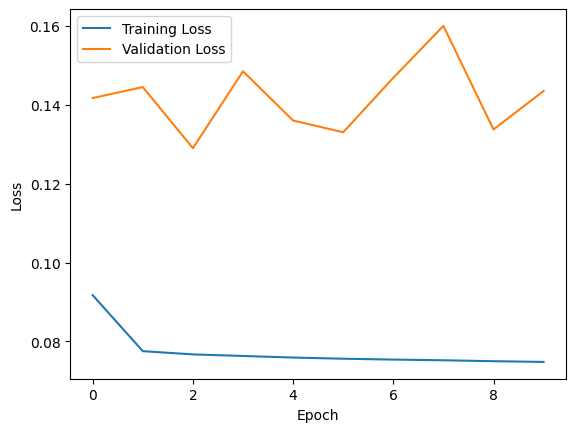

In [ ]:
plt.plot([x for x in range(10)], train_loss_list)
plt.plot([x for x in range(10)], val_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

In [ ]:
from torchvision.utils import make_grid, save_image

# base_model = BaseModel()
# # base_model.load_state_dict(torch.load('best_model.pth'))
# base_model.eval()

# adaptive_model = AdaptiveDiffusionModel(
#     base_model=base_model,
#     input_dim=28 * 28,
#     alpha=1.0,
#     tau=0.5,
#     lambda_reg=0.1
# )

# adaptive_model.load_state_dict(torch.load('best_model.pth'))

# adaptive_model.eval()

samples = trained_model.sample(n=16, num_steps=20)

os.makedirs("samples", exist_ok=True)

save_image(samples, "samples/generated_grid.png", nrow=4)



